# Can Deep Learning Discern a Portrait Artist's Gender?

## Introduction

Anecdotally, certain artists throughout history have been vaunted for their feminine or masculine art styles, particularly when depicting human forms. Also, the recent popularity the subreddit [r/MenDrawingWomen](https://www.reddit.com/r/mendrawingwomen/) has highlighted some of the vulgar inaccuracies of some male artist's depictions of the female body. Realistically I do not think I am personally able to determine an artist's gender purely based on their art.

But are there visual elements in portrait art contain sutble clues to an artist's gender? If so perhaps the rapidly evolving deep learning image classification models would be able to discern an artist's gender based on artwork alone.

## Aim
Use state-of-the-art image classification techniques to analyse portraits across a diverse range of artists to classify artist's gender significantly better than in 50% of cases.

## Data Preparation
Through research the [Kaggle Painter By Numbers](https://www.kaggle.com/c/painter-by-numbers) dataset was obtained. A subset of 3636 portraits (excluding self-portraits). To narrow the range of art styles, only portraits created year 1900 or later across a variety of styles were included. 

Each artist was manually referenced against Wikipedia data to determine their gender with males labelled '0' and females labelled '1'. Notably, only 400 of the 3636 portraits was by a female artist so class imbalance would need to be addressed.

A 80% train / 20% validation split of the dataset was performed.

In [1]:
# General Imports
import random
import os
import shutil
import sys
from IPython.display import Image
random.seed(99)
import pandas as pd

# SKLearn Imports
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

# Model Imports
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread

# Display Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from PIL import Image
Image.MAX_IMAGE_PIXELS = None # https://pillow.readthedocs.io/en/5.1.x/releasenotes/5.0.0.html#decompression-bombs-now-raise-exceptions

In [2]:
# Data Preparation

# Set Paths
base_datapath = os.path.dirname(__file__)
femme_path = os.path.join(base_datapath, '/femme/')
homme_path = os.path.join(base_datapath, '/homme/')

# Split images into folders by class
# # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
# raw_data = pd.read_csv('portrait_data1.csv', header=0)
# data_ref = raw_data.fillna(0) # replace NaN with 0

# # create folders of femme and homme images
# for idx, row in raw_data.iterrows():
#     if idx ==0:
#         pass
#     elif row[6] == 1.0: # copy femme art files to folder 'femme'
#         if os.path.isfile(os.path.join(base_datapath,row[5])):
#             shutil.copy(os.path.join(base_datapath,row[5]), os.path.join(femme_path,row[5]))
#     else: # copy homme art files to folder 'homme'
#         if os.path.isfile(os.path.join(base_datapath,row[5])):
#             shutil.copy(os.path.join(base_datapath,row[5]), os.path.join(homme_path,row[5]))

# Create Train + Validate Sets
parent_datapath = os.path.join(base_datapath, '/data/')
train_dir = os.path.join(base_datapath, '/data/train')
valid_dir = os.path.join(base_datapath, '/data/valid')
train_femme_dir = os.path.join(base_datapath, '/data/train/femme')
train_homme_dir = os.path.join(base_datapath, '/data/train/homme')
valid_femme_dir = os.path.join(base_datapath, '/data/valid/femme')
valid_homme_dir = os.path.join(base_datapath, '/data/valid/homme')

# # Copy first NUM_TRAIN//2 cat images to train_cats_dir
# fnames = femme_list[:int((len(femme_list)*TRAIN_PCT))]
# for fname in fnames:
#     dst = os.path.join(train_femme_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# # Copy first NUM_TRAIN//2 cat images to train_cats_dir
# fnames = homme_list[:int((len(homme_list)*TRAIN_PCT))]
# for fname in fnames:
#     dst = os.path.join(train_homme_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# # Copy first NUM_TRAIN//2 cat images to train_cats_dir
# fnames = femme_list[int((len(femme_list)*TRAIN_PCT)):]
# for fname in fnames:
#     dst = os.path.join(valid_femme_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# # Copy first NUM_TRAIN//2 cat images to train_cats_dir
# fnames = homme_list[int((len(homme_list)*TRAIN_PCT)):]
# for fname in fnames:
#     dst = os.path.join(valid_homme_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# https://docs.python.org/3/library/glob.html
femme_list = glob.glob(os.path.join(femme_path,'*.jpg'))
homme_list = glob.glob(os.path.join(homme_path,'*.jpg'))
print('femme_list:',len(femme_list))
print('homme_list:',len(homme_list))

femme_list: 400
homme_list: 3236


## Model Selection

I reviewed the 2020 state-of-the-art image classifcation models for transfer learning/fine-tuning, noisy student and efficientnet models stood out as best performers on the imagenet benchmark.

Looking over the noisy student paper, this model improved its initial model results with further unlabelled data, which I do not currently posses. Efficientnet was loosely based on resnet but less resource intensive without sacrificing performance. Thus, the simplest version efficientnet-b0 was chosen and [Chengwei Zhang's Keras-based efficientnet transfer learning notebook](https://github.com/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb) used for reference.



In [3]:
# !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/Users/ap/Documents/NFL Dynasty/artistgender/efficientnet_keras_transfer_learning


In [4]:
# Imports and Model Parameters
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

batch_size = 48

width = 150
height = 150
epochs = 20
TRAIN_PCT = 0.8
dropout_rate = 0.2
input_shape = (height, width, 3)

Using TensorFlow backend.


In [5]:
# loading pretrained conv base model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

NUM_TRAIN = 2908
NUM_TEST = 728

Found 2908 images belonging to 2 classes.
Found 728 images belonging to 2 classes.


In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [8]:
# Plot Accuracy & Loss function

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'acc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


### Baseline Model 0 with imbalanced data (no class weights)

In [ ]:
conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc','loss', 'auc', 'precision', 'recall']) # metrics=['acc']
m0_history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
plot_metrics(m0_history)

In [12]:
# Predict Validation Set and Generate Confusion Matrix
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
Y_pred = model.predict_generator(validation_generator, NUM_TEST // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[ 61  19]
 [451 197]]


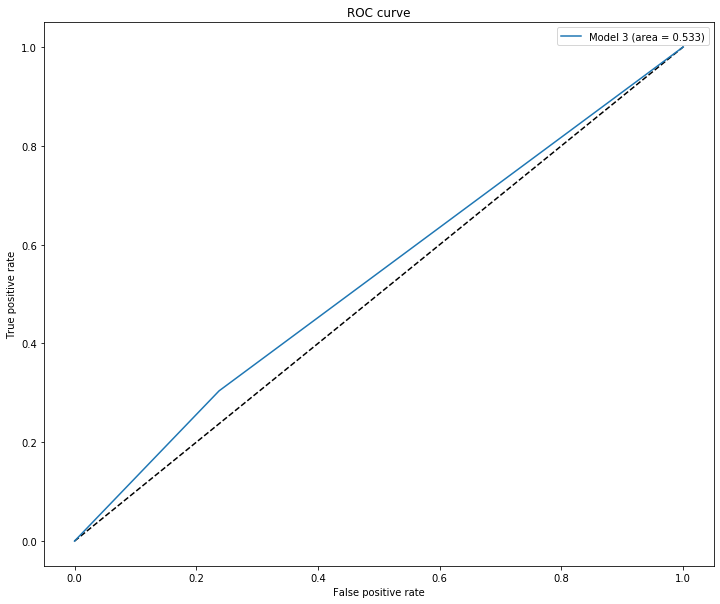

In [14]:
# Generate ROC curve
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
fpr_keras, tpr_keras, thresholds_keras = roc_curve(validation_generator.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Model 3 (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Output - Baseline Model 0 with imbalanced data (no class weights)
The confusion matrix suggests the model is overly incentivised to predict 'male' due the the data imbalance.

 #### Training Accuracy & Loss
 
![model0_acc_loss](img/model0_acc_loss.png)
 
#### Confusion Matrix

[[ 3  77 ]
 
 [ 7 641 ]]
 
#### ROC Curve
![model0_roc_curve](img/model0_roc_curve.png)


 - Model is essentially predicting male artist almost everytime time

### Model 1: Introducing Proportional Class Weights

In [10]:
# https://androidkt.com/set-class-weight-for-imbalance-dataset-in-keras/
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
train_label_counts = np.zeros(320)
train_label_counts = np.append(train_label_counts, np.ones(2588))

class_weights = class_weight.compute_class_weight('balanced',
                                                 [0,1],
                                                 train_label_counts)
class_weights = dict(enumerate(class_weights))
class_weights

# class_weights {0: 4.54375, 1: 0.5618238021638331}
smoothed_class_weights= {0: 1, 1: 4.54375}
print("class_weights:",class_weights)
print("smoothed_class_weights:",smoothed_class_weights, "(halved weighting)")

class_weights: {0: 4.54375, 1: 0.5618238021638331}
smoothed_class_weights: {0: 1, 1: 4.54375} (halved weighting)


In [ ]:
# Basline Model 1 with class weights

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc','AUC']) # metrics=['acc']

m1_history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      class_weight=class_weights,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
plot_metrics(m1_history)

### Model 1 with class weights of proportional values
The introduction of class weights that are proportional to the class imbalance modestly improve the number of correctly predicted female artists, but at the cost of a significant increase in misclassifed male artists. Consequently, the ROC curve demonstrates the area-under-curve is less than 0.5.

#### Training Accuracy & Loss
 
![model1_acc_loss](img/model1_acc_loss.png)

#### Confusion Matrix
 
[[ 27  53]

 [289 359]]
 
 #### ROC Curve
![model1_roc_curve](img/model1_roc_curve.png)

 
 - Seems overly skewed towards female class, approx 25% accuracy

### Model 2 - Finetune last few layers (with proportional class weights)

In [ ]:
# Model 2 - Finetune last few layers (with proportional class weights)

# https://github.com/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc','AUC']) # metrics=['acc']

m2_history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      class_weight=class_weights,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
plot_metrics(m2_history)

### Output - Model 2 - Finetune last few layers (with proportional class weights)
Configuring the model to fine-tune the final layers further increases the correctly classified female artists but the male classifications has worsened further. The ROC curve suggests model 2 outperforms model 1, but is still with and area-under-curve of 0.56 and not materially improved over random guessing.

#### Training Accuracy & Loss
 
![model2_acc_loss](img/model2_acc_loss.png)

#### Confusion Matrix

[[ 64  16]

 [436 212]]
 
#### ROC Curve
![model2_roc_curve](img/model2_roc_curve.png)

### Model 3 - smoothed class weights without finetune

This is the number of trainable layers after freezing the conv base: 2
Epoch 1/20
60/60 [==============================] - 126s 2s/step - loss: 1.9499 - acc: 0.3769 - auc_2: 0.3417 - val_loss: 2.0208 - val_acc: 0.2611 - val_auc_2: 0.2136
Epoch 2/20
60/60 [==============================] - 125s 2s/step - loss: 1.5919 - acc: 0.5206 - auc_2: 0.5263 - val_loss: 1.6207 - val_acc: 0.3333 - val_auc_2: 0.2922
Epoch 1/20Epoch 3/20
60/60 [==============================] - 127s 2s/step - loss: 1.7702 - acc: 0.5385 - auc_2: 0.5524 - val_loss: 1.6386 - val_acc: 0.3292 - val_auc_2: 0.2896
Epoch 4/20
60/60 [==============================] - 125s 2s/step - loss: 1.6680 - acc: 0.5220 - auc_2: 0.5394 - val_loss: 1.6048 - val_acc: 0.3361 - val_auc_2: 0.2986
Epoch 1/20
Epoch 5/20
60/60 [==============================] - 125s 2s/step - loss: 1.6092 - acc: 0.5490 - auc_2: 0.5728 - val_loss: 1.5744 - val_acc: 0.3472 - val_auc_2: 0.3056
Epoch 6/20
60/60 [==============================] - 127s 2s/step - loss: 

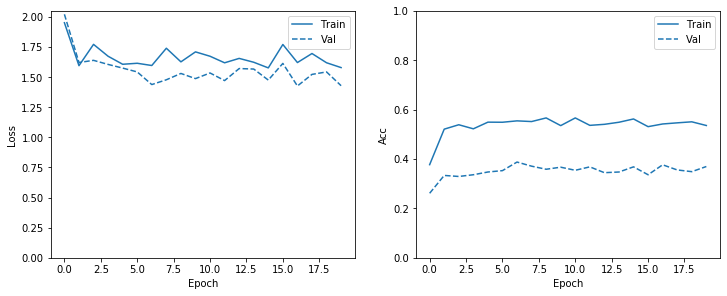

In [11]:
# Model 3 - smoothed class weights (without finetune)

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc','AUC']) # metrics=['acc']

m3_history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      class_weight=class_weights,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
plot_metrics(m3_history)

### Output - Model 3 - smoothed class weights without finetune
Given model 2's extreme focus on correctly predicting female artists, I thought to halve the female class weight and remove finetuning to see if the improvement in male artist prediction would generally improve the model. However, as the ROC curve shows, it sacrificed the female predictive ability more than it benefited male prediction to reuslt in an area-under-curve of just 0.533.
#### Training Accuracy & Loss
 
![model3_acc_loss](img/model3_acc_loss.png)

#### Confusion Matrix

[[ 61  19]

 [451 197]]

 
 #### ROC Curve
![model3_roc_curve](img/model3_roc_curve.png)

### Model 4 - smoothed class weights with finetune

In [ ]:
# Model 4 - smoothed class weights (WITH finetune)

# https://github.com/Tony607/efficientnet_keras_transfer_learning/blob/master/Keras_efficientnet_transfer_learning.ipynb
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc','AUC']) # metrics=['acc']

m4_history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      class_weight=smoothed_class_weights,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)
plot_metrics(m4_history)

### Output - Model 4 - smoothed class weights (WITH finetune)
For the sake of comparision, model 4 maintained the halved class weights of model 3 but included finetuning. Unfortunately this reverted the model to overly focusing on predicting male artists correctly and the area-under-curve remained low at 0.515.

#### Training Accuracy & Loss
 
![model4_acc_loss](img/model4_acc_loss.png)


#### Confusion Matrix
 
[[  9  71]

 [ 53 595]]
 
#### ROC Curve
![model4_roc_curve](img/model4_roc_curve.png)

## Conclusion
After implementing proportional class weights to overcome class imbalance and fine-tuning the base model, there was not significant improvement in predictive performance. There is no suggestion in this simple exploration that state-of-the-art image classification models are able to discern a portrait artist's gender above a baseline of 50%.

## Future Work
Perhaps by narrowing the range of styles in the dataset to simpler brush stroke art, such as monochrome manga or webcomics, there may be some improvements to performance and this may be explored in further work.

Also, it would be beneficial to source an independent test set for better model comparision.